# Assignment 2: Simple multi layer perceptron

In [1]:
import functools as ft
import typing as ty

import matplotlib.pyplot as plt
import mnist as mnist_loader
import numpy as np
import numpy.typing as npt
import pandas as pd
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, roc_curve
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

np.random.seed(0x0D000721)
t.manual_seed(0x0D000721)

DPI = 200

## 1. Algorithm

### 1.1. Nonlinear functions

* Rectified linear units (ReLU): $f_{\mathrm{ReLU}}(x) = \mathrm{max}\{0, x\}$
* Sigmoid: $f_{\mathrm{sigmoid}}(x) = \frac{1}{1 + e^{-x}}$
* Softmax: $f_{\mathrm{softmax}}(\bm{x})_i = \frac{e^{x_i}}{\sum_{j} e^{x_j}}$
* Tanh: $f_{\mathrm{tanh}}(x) = \mathrm{tanh}(x)$

### 1.2. Perceptron

$$
p(\bm{x}, \bm{A}, \bm{b}):\ \bm{y} = f_{\mathrm{act}}(\bm{x} \bm{A}^\intercal + \bm{b})
$$

where $f_{\mathrm{act}}$ is some nonlinear function ("activation function"). $\bm{A}$ and $\bm{b}$ are trainable parameters.

### 1.3. Deeper networks

Denote each layer function as $f_{\mathrm{layer}}(\bm{x}, \theta)$:

$$
N(\bm{x}, \bm{\theta}):\ \bm{y} = \left(\underset{i \in I}{\mathop{\bigcirc}}\ f_{\mathrm{layer}\ i}\left(\cdot, \theta\right)\right)\left(\bm{x}\right)
$$

### 1.4. Supervised training

Given observations $\bm{x}_s$ and respective truths $\bm{y}_s$, training is framed as the following optimization problem:

$$
\hat{\bm{\theta}} = \underset{\bm{\theta}}{\arg\min}\ f_{\mathrm{loss}}\left(N\left(\bm{x}_s, \bm{\theta}\right), \bm{y}_s\right)
$$

where $f_{\mathrm{loss}}$ is some distance ("loss") defined on the truth space.

## 2. Experiment setup

### 2.1. Dataset preparation

In [2]:
with np.load("../dataset/mnist.npz") as mnist:
    mnist_x_train, mnist_y_train = mnist["x_train"], mnist["y_train"]
    mnist_x_test, mnist_y_test = mnist["x_test"], mnist["y_test"]

mnist_x_train = (
    mnist_x_train.reshape((mnist_x_train.shape[0], -1)).astype(np.float32) / 255.0
)
mnist_y_train = mnist_y_train.astype(np.int_)
mnist_x_test = (
    mnist_x_test.reshape((mnist_x_test.shape[0], -1)).astype(np.float32) / 255.0
)
mnist_y_test = mnist_y_test.astype(np.int_)

print(f"mnist_x_train.shape: {mnist_x_train.shape} dtype={mnist_x_train.dtype}")
print(f"mnist_y_train.shape: {mnist_y_train.shape} dtype={mnist_y_train.dtype}")
print(f"mnist_x_test.shape: {mnist_x_test.shape} dtype={mnist_x_test.dtype}")
print(f"mnist_y_test.shape: {mnist_y_test.shape} dtype={mnist_y_test.dtype}")

mnist_n_labels = max(int(mnist_y_train.max()), int(mnist_y_test.max())) + 1
print(f"mnist_n_labels = {mnist_n_labels}")
assert mnist_n_labels == 10

fashion_loader = mnist_loader.MNIST("../dataset/fashion_mnist", gz=True)
fashion_x_train, fashion_y_train = fashion_loader.load_training()
fashion_x_test, fashion_y_test = fashion_loader.load_testing()

fashion_x_train = np.array(fashion_x_train)
fashion_y_train = np.array(fashion_y_train)
fashion_x_test = np.array(fashion_x_test)
fashion_y_test = np.array(fashion_y_test)

fashion_x_train = (
    fashion_x_train.reshape((fashion_x_train.shape[0], -1)).astype(np.float32) / 255.0
)
fashion_y_train = fashion_y_train.astype(np.int_)
fashion_x_test = (
    fashion_x_test.reshape((fashion_x_test.shape[0], -1)).astype(np.float32) / 255.0
)
fashion_y_test = fashion_y_test.astype(np.int_)

print(f"fashion_x_train.shape: {fashion_x_train.shape} dtype={fashion_x_train.dtype}")
print(f"fashion_y_train.shape: {fashion_y_train.shape} dtype={fashion_y_train.dtype}")
print(f"fashion_x_test.shape: {fashion_x_test.shape} dtype={fashion_x_test.dtype}")
print(f"fashion_y_test.shape: {fashion_y_test.shape} dtype={fashion_y_test.dtype}")

fashion_n_labels = max(int(fashion_y_train.max()), int(fashion_y_test.max())) + 1
print(f"fashion_n_labels = {fashion_n_labels}")
assert fashion_n_labels == 10

mnist_x_train.shape: (60000, 784) dtype=float32
mnist_y_train.shape: (60000,) dtype=int64
mnist_x_test.shape: (10000, 784) dtype=float32
mnist_y_test.shape: (10000,) dtype=int64
mnist_n_labels = 10
fashion_x_train.shape: (60000, 784) dtype=float32
fashion_y_train.shape: (60000,) dtype=int64
fashion_x_test.shape: (10000, 784) dtype=float32
fashion_y_test.shape: (10000,) dtype=int64
fashion_n_labels = 10


### 2.2. Baseline model structure

Our baseline model (append batch size $B$ in front of all shapes):

1. FC1: 784 -> 128
2. ReLU1
3. FC2: 128 -> 64
4. ReLU2
5. FC3: 64 -> 10
6. Softmax

In [3]:
class MLPBaseline(nn.Module):
    def __init__(self):
        super(MLPBaseline, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

BASELINE_MODEL = MLPBaseline()

### 2.3. Differential models

We mutate the models in activation functions and layer count.

* Activation: ReLU (baseline), Tanh, Sigmoid
* Layer count: 1, 2, 3 (baseline), 4, 5

In [4]:
class MLPVarActivation(nn.Module):
    def __init__(self, activation):
        super(MLPVarActivation, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.activation = activation

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

VAR_ACT_MODELS: dict[ty.Literal["tanh", "sigmoid"], nn.Module] = {
    "tanh": MLPVarActivation(activation=F.tanh),
    "sigmoid": MLPVarActivation(activation=F.sigmoid),
}

class MLPVarLayer(nn.Module):
    def __init__(self, hidden_features: list[int]):
        super(MLPVarLayer, self).__init__()
        self.hidden_layers = nn.ModuleList()
        if len(hidden_features) > 0:
            self.hidden_layers.append(nn.Linear(784, hidden_features[0]))
            for i in range(1, len(hidden_features)):
                self.hidden_layers.append(nn.Linear(hidden_features[i - 1], hidden_features[i]))
            self.output_layer = nn.Linear(hidden_features[-1], 10)
        else:
            self.output_layer = nn.Linear(784, 10)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
            x = F.relu(x)
        x = self.output_layer(x)
        x = F.softmax(x, dim=1)
        return x

VAR_LAYER_MODELS: dict[ty.Literal[1, 2, 4, 5], nn.Module] = {
    1: MLPVarLayer(hidden_features=[]),
    2: MLPVarLayer(hidden_features=[128]),
    4: MLPVarLayer(hidden_features=[128, 64, 32]),
    5: MLPVarLayer(hidden_features=[256, 128, 64, 32]),
}

Another differential model is a simple convolution model.

In [5]:
class ConvClassifier(nn.Module):
    def __init__(self, p_dropout=0.2):
        super(ConvClassifier, self).__init__()
        # Input: (B, 784) -> (B, 1, 28, 28)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)  # -> (B, 32, 24, 24)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=5)  # -> (B, 16, 20, 20)
        self.fc1 = nn.Linear(16 * 20 * 20, 128)  # -> (B, 128)
        self.fc2 = nn.Linear(128, 10)  # -> (B, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 16 * 20 * 20)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x


CONV_MODEL = ConvClassifier()

### 2.4. Training and evaluation

We use the Adam (<https://arxiv.org/abs/1412.6980>) optimizer with $lr=0.0001$ for a fixed $100$ epochs. Each round, all training samples are passed forward in batches of $B=128$.

In [6]:
def train(
    model: nn.Module,
    x_train,
    y_train,
    x_test,
    y_test,
    epochs=100,
    batch_size=128,
    lr=0.0001,
) -> tuple[list[float], list[float]]:
    optimizer = t.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_dataset = TensorDataset(t.from_numpy(x_train), t.from_numpy(y_train).long())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    x_test = t.from_numpy(x_test)
    y_test = t.from_numpy(y_test).long()

    acc_hist = []
    loss_hist = []

    with tqdm(total=epochs) as pbar:
        for _ in range(epochs):
            model.train()
            total_loss = 0

            for x_batch, y_batch in train_loader:
                optimizer.zero_grad()
                output = model(x_batch)
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)

            model.eval()
            with t.inference_mode():
                test_pred = model(x_test).argmax(dim=1)
                test_acc = (test_pred == y_test).float().mean().item()

            acc_hist.append(test_acc)
            loss_hist.append(avg_loss)
            pbar.set_postfix(loss=avg_loss, acc=test_acc)
            pbar.update(1)

    return acc_hist, loss_hist

In [7]:
baseline_training_log = train(BASELINE_MODEL, mnist_x_train, mnist_y_train, mnist_x_test, mnist_y_test)
var_act_training_logs = {
    k: train(v, mnist_x_train, mnist_y_train, mnist_x_test, mnist_y_test)
    for k, v in VAR_ACT_MODELS.items()
}
var_layer_training_logs = {
    k: train(v, mnist_x_train, mnist_y_train, mnist_x_test, mnist_y_test)
    for k, v in VAR_LAYER_MODELS.items()
}

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

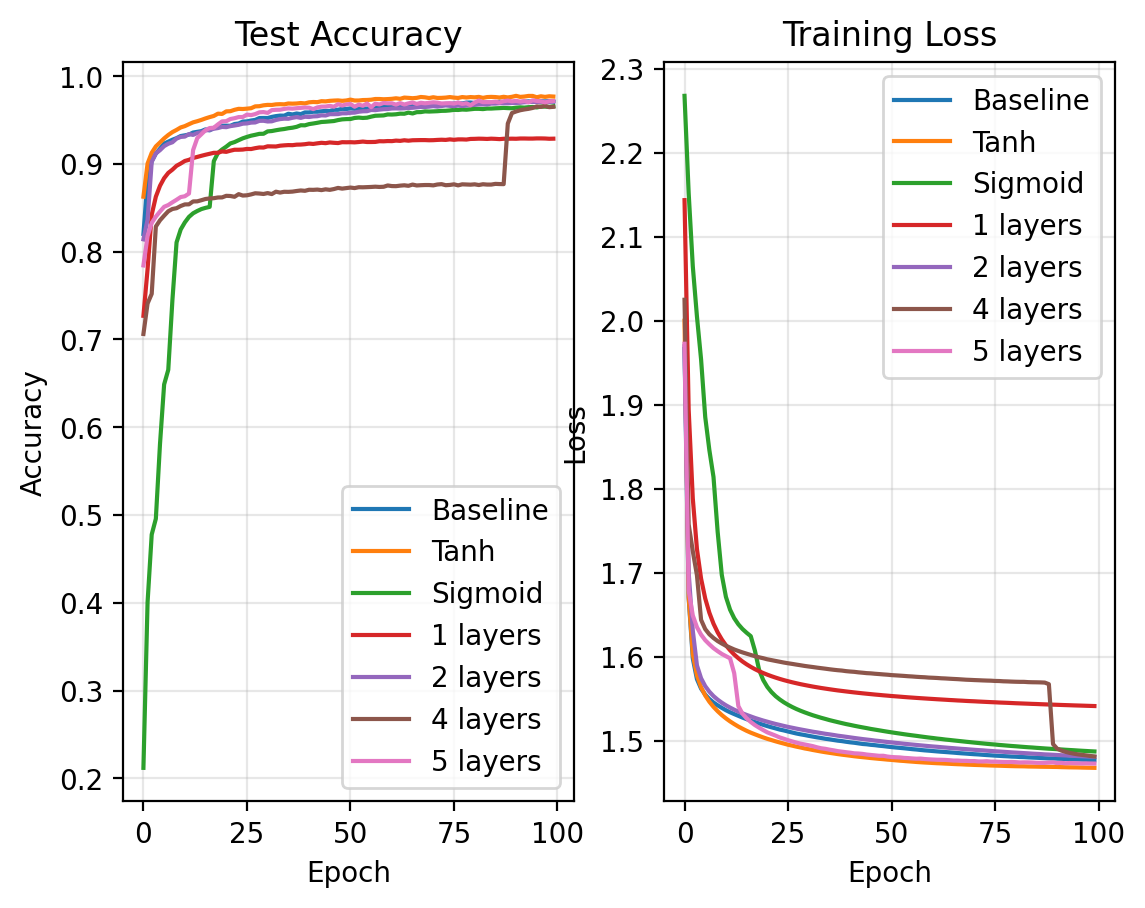

In [8]:
plt.close("all")

fig, ax = plt.subplots(1, 2, dpi=DPI)
fig.canvas.header_visible = False

# Plot accuracy curves
ax[0].plot(baseline_training_log[0], label='Baseline', linewidth=1.5)
for name, (acc_hist, _) in var_act_training_logs.items():
    ax[0].plot(acc_hist, label=f'{name.capitalize()}', linewidth=1.5)
for n_layers, (acc_hist, _) in var_layer_training_logs.items():
    ax[0].plot(acc_hist, label=f'{n_layers} layers', linewidth=1.5)

ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Test Accuracy')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Plot loss curves
ax[1].plot(baseline_training_log[1], label='Baseline', linewidth=1.5)
for name, (_, loss_hist) in var_act_training_logs.items():
    ax[1].plot(loss_hist, label=f'{name.capitalize()}', linewidth=1.5)
for n_layers, (_, loss_hist) in var_layer_training_logs.items():
    ax[1].plot(loss_hist, label=f'{n_layers} layers', linewidth=1.5)

ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.show()

## 3. Evaluation

In [9]:
class BinPredEvalResult(ty.NamedTuple):
    tp: int
    fp: int
    tn: int
    fn: int

    @property
    def accuracy(self) -> float:
        return (self.tp + self.tn) / (self.tp + self.fp + self.tn + self.fn)

    @property
    def recall(self) -> float:
        return self.tp / (self.tp + self.fn) if (self.tp + self.fn) > 0 else 0.0

    @property
    def precision(self) -> float:
        return self.tp / (self.tp + self.fp) if (self.tp + self.fp) > 0 else 0.0

    @property
    def f1_score(self) -> float:
        prec = self.precision
        rec = self.recall
        return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0


def eval_bin_classif(
    model: nn.Module, x_test, y_test, target_class: int
) -> tuple[BinPredEvalResult, float]:
    assert 0 <= target_class <= 9
    model.eval()
    with t.inference_mode():
        yhat = model(t.from_numpy(x_test))
    yhat_bin = yhat.argmax(dim=1) == target_class
    y_bin = y_test == target_class
    yhat_scores = yhat[:, target_class].numpy()

    tp = (yhat_bin & y_bin).sum().item()
    fp = (yhat_bin & ~y_bin).sum().item()
    tn = (~yhat_bin & ~y_bin).sum().item()
    fn = (~yhat_bin & y_bin).sum().item()

    roc_auc = roc_auc_score(y_bin, yhat_scores)

    return BinPredEvalResult(tp=tp, fp=fp, tn=tn, fn=fn), roc_auc

### 3.1. Precision, Recall and F1

In [10]:
LABELS = (6, 9)

bin_results: dict[int, pd.DataFrame] = {}
for label in LABELS:
    baseline_bin_result = eval_bin_classif(
        BASELINE_MODEL, mnist_x_test, mnist_y_test, target_class=label
    )
    var_act_bin_results = {
        k: eval_bin_classif(
            VAR_ACT_MODELS[k], mnist_x_test, mnist_y_test, target_class=label
        )
        for k in VAR_ACT_MODELS
    }
    var_layer_bin_results = {
        k: eval_bin_classif(
            VAR_LAYER_MODELS[k], mnist_x_test, mnist_y_test, target_class=label
        )
        for k in VAR_LAYER_MODELS
    }

    data = {
        "Baseline": {
            "Precision": baseline_bin_result[0].precision,
            "Recall": baseline_bin_result[0].recall,
            "F1": baseline_bin_result[0].f1_score,
            "AUC of ROC": baseline_bin_result[1]
        }
    }
    for k in var_act_bin_results:
        bin_metrics = var_act_bin_results[k][0]
        data[k.capitalize()] = {
            "Precision": bin_metrics.precision,
            "Recall": bin_metrics.recall,
            "F1": bin_metrics.f1_score,
            "AUC of ROC": var_act_bin_results[k][1]
        }
    for k in var_layer_bin_results:
        bin_metrics = var_layer_bin_results[k][0]
        data[f"{k} Layers"] = {
            "Precision": bin_metrics.precision,
            "Recall": bin_metrics.recall,
            "F1": bin_metrics.f1_score,
            "AUC of ROC": var_layer_bin_results[k][1]
        }
    df = pd.DataFrame(data).T
    bin_results[label] = df

/tmp/ipykernel_208002/2563237706.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  tp = (yhat_bin & y_bin).sum().item()
/tmp/ipykernel_208002/2563237706.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  fp = (yhat_bin & ~y_bin).sum().item()
/tmp/ipykernel_208002/2563237706.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  tn = (~yhat_bin & ~y_bin).sum().item()
/tmp/ipykernel_208002/2563237706.py:40: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  fn = (~yhat_bin & y_bin).sum().item()
/tmp/ipykernel_208002/2563237706.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally

In [11]:
print('Label "6"')
bin_results[6]

Label "6"


,Precision,Recall,F1,AUC of ROC
Baseline,0.976866,0.969729,0.973284,0.999475
Tanh,0.975104,0.981211,0.978148,0.999212
Sigmoid,0.967775,0.971816,0.969792,0.999341
1 Layers,0.937307,0.951983,0.944588,0.997995
2 Layers,0.973849,0.971816,0.972832,0.999402
4 Layers,0.965732,0.970772,0.968246,0.999419
5 Layers,0.977848,0.967641,0.972718,0.998787


In [12]:
print('Label "9"')
bin_results[9]

Label "9"


,Precision,Recall,F1,AUC of ROC
Baseline,0.976578,0.950446,0.963335,0.997091
Tanh,0.981818,0.963330,0.972486,0.999079
Sigmoid,0.960566,0.941526,0.950951,0.995096
1 Layers,0.917255,0.900892,0.909000,0.988898
2 Layers,0.977551,0.949455,0.963298,0.997338
4 Layers,0.954183,0.949455,0.951813,0.996542
5 Layers,0.968032,0.960357,0.964179,0.997539


### 3.2. ROC curves

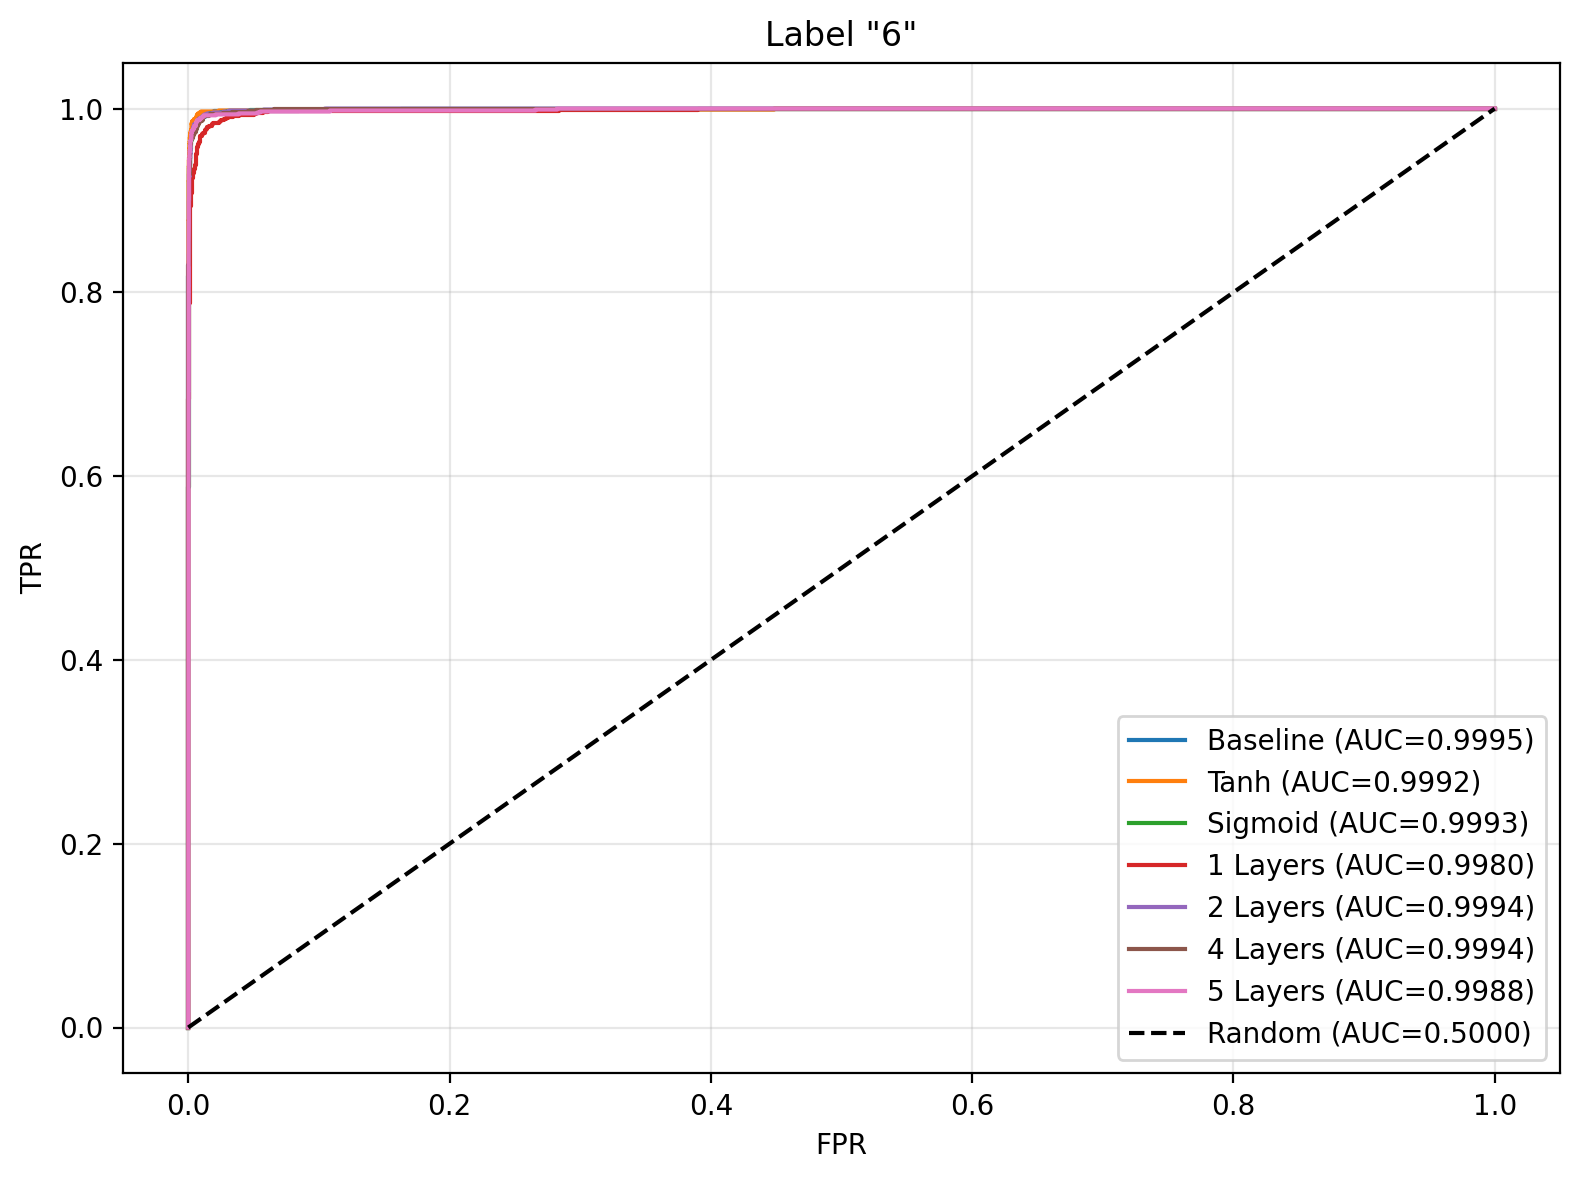

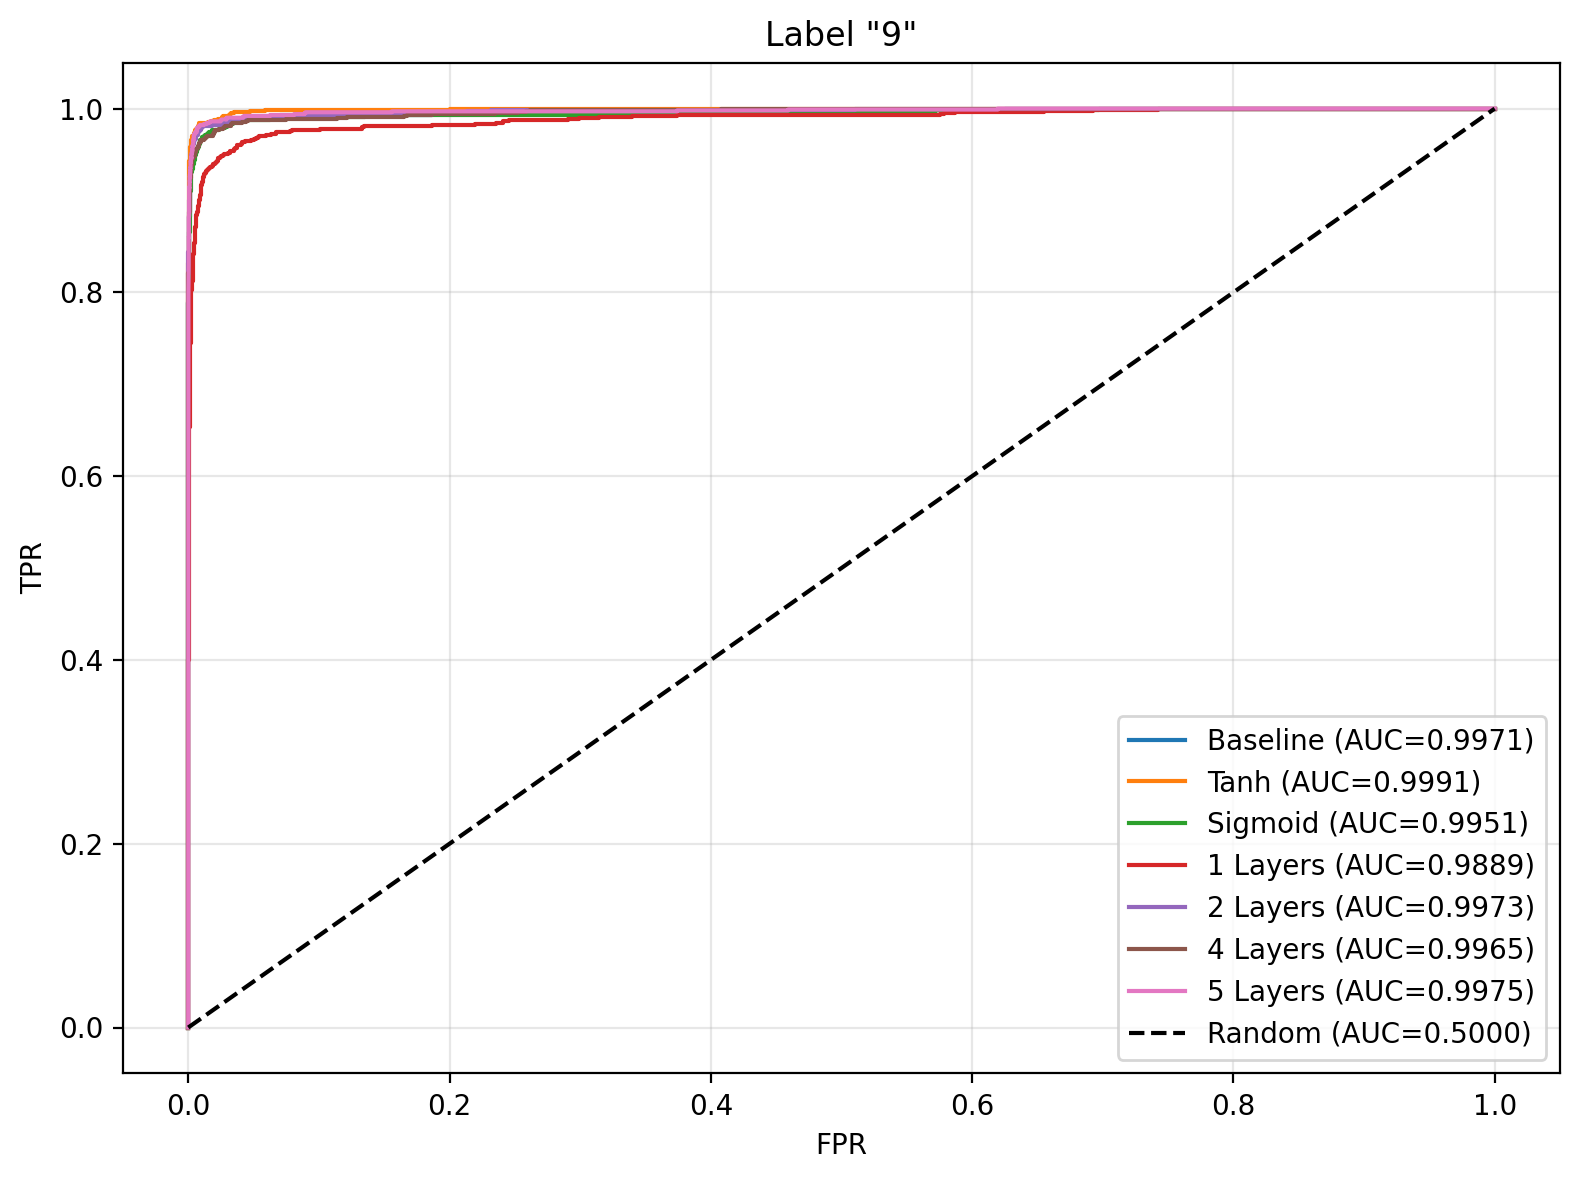

In [13]:
plt.close("all")

all_models: dict[str, nn.Module] = {
    "Baseline": BASELINE_MODEL,
}
all_models.update({k.capitalize(): v for k, v in VAR_ACT_MODELS.items()})
all_models.update({f"{k} Layers": v for k, v in VAR_LAYER_MODELS.items()})

for i, label in enumerate(LABELS):
    plt.figure(figsize=(8, 6), dpi=DPI)

    for model_name, model in all_models.items():
        model.eval()
        with t.inference_mode():
            yhat = model(t.from_numpy(mnist_x_test))

        y_bin = mnist_y_test == label
        yhat_score = yhat[:, label].numpy()

        fpr, tpr, _ = roc_curve(y_bin, yhat_score)
        auc = roc_auc_score(y_bin, yhat_score)

        plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc:.4f})", linewidth=1.5)

    plt.plot([0, 1], [0, 1], "k--", label="Random (AUC=0.5000)", linewidth=1.5)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f'Label "{label}"')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 4. Comparison with convolution model

### 4.1. MNIST

In [14]:
train(CONV_MODEL, mnist_x_train, mnist_y_train, mnist_x_test, mnist_y_test)

  0%|          | 0/100 [00:00<?, ?it/s]

([0.90420001745224,
  0.932200014591217,
  0.9491999745368958,
  0.9624000191688538,
  0.9677000045776367,
  0.975600004196167,
  0.9782000184059143,
  0.9800999760627747,
  0.9815000295639038,
  0.9825000166893005,
  0.984499990940094,
  0.9860000014305115,
  0.9868999719619751,
  0.9858999848365784,
  0.9851999878883362,
  0.9865000247955322,
  0.9871000051498413,
  0.9883000254631042,
  0.9872999787330627,
  0.9882000088691711,
  0.9866999983787537,
  0.9882000088691711,
  0.9868000149726868,
  0.9878000020980835,
  0.9876999855041504,
  0.9889000058174133,
  0.9873999953269958,
  0.9886999726295471,
  0.9883999824523926,
  0.9882000088691711,
  0.9886999726295471,
  0.9884999990463257,
  0.9886999726295471,
  0.989300012588501,
  0.9889000058174133,
  0.9876999855041504,
  0.9882000088691711,
  0.9883000254631042,
  0.9882000088691711,
  0.9884999990463257,
  0.9864000082015991,
  0.9883999824523926,
  0.9878000020980835,
  0.9887999892234802,
  0.9872000217437744,
  0.988900005817

In [15]:
conv_fashion_results: dict[int, pd.Series] = {}

for k in LABELS:
    conv_result = eval_bin_classif(CONV_MODEL, mnist_x_test, mnist_y_test, k)
    data = {
        "Precision": conv_result[0].precision,
        "Recall": conv_result[0].recall,
        "F1": conv_result[0].f1_score,
        "AUC of ROC": conv_result[1],
    }
    conv_fashion_results[k] = pd.Series(data)

baseline_mnist_results = {k: bin_results[k].T["Baseline"] for k in bin_results}

conv_baseline_results = {
    k: pd.DataFrame(
        {"Conv": conv_fashion_results[k], "Baseline": baseline_mnist_results[k]}
    ).T
    for k in LABELS
}

/tmp/ipykernel_208002/2563237706.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  tp = (yhat_bin & y_bin).sum().item()
/tmp/ipykernel_208002/2563237706.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  fp = (yhat_bin & ~y_bin).sum().item()
/tmp/ipykernel_208002/2563237706.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  tn = (~yhat_bin & ~y_bin).sum().item()
/tmp/ipykernel_208002/2563237706.py:40: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  fn = (~yhat_bin & y_bin).sum().item()
/tmp/ipykernel_208002/2563237706.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally

In [16]:
conv_baseline_results[LABELS[0]]

,Precision,Recall,F1,AUC of ROC
Conv,0.988542,0.990605,0.989572,0.999881
Baseline,0.976866,0.969729,0.973284,0.999475


In [17]:
conv_baseline_results[LABELS[1]]

,Precision,Recall,F1,AUC of ROC
Conv,0.982283,0.989098,0.985679,0.999811
Baseline,0.976578,0.950446,0.963335,0.997091


### 4.2. FashionMNIST

In [18]:
BASELINE_MODEL = MLPBaseline()
CONV_MODEL = ConvClassifier()

train(BASELINE_MODEL, fashion_x_train, fashion_y_train, fashion_x_test, fashion_y_test)
train(CONV_MODEL, fashion_x_train, fashion_y_train, fashion_x_test, fashion_y_test)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

([0.76419997215271,
  0.7994999885559082,
  0.8144000172615051,
  0.8245000243186951,
  0.8274999856948853,
  0.8396000266075134,
  0.8418999910354614,
  0.8449000120162964,
  0.8492000102996826,
  0.8489999771118164,
  0.8460000157356262,
  0.8546000123023987,
  0.8568999767303467,
  0.8561000227928162,
  0.862500011920929,
  0.8666999936103821,
  0.8618000149726868,
  0.8669999837875366,
  0.8707000017166138,
  0.8654000163078308,
  0.8761000037193298,
  0.8729000091552734,
  0.8769000172615051,
  0.8816999793052673,
  0.8780999779701233,
  0.8808000087738037,
  0.8847000002861023,
  0.8835999965667725,
  0.8812000155448914,
  0.8865000009536743,
  0.8830999732017517,
  0.883899986743927,
  0.8867999911308289,
  0.887499988079071,
  0.8894000053405762,
  0.8906999826431274,
  0.8906000256538391,
  0.8873000144958496,
  0.8885999917984009,
  0.890500009059906,
  0.890999972820282,
  0.8932999968528748,
  0.8948000073432922,
  0.8942000269889832,
  0.894599974155426,
  0.89399999380111

In [19]:
conv_baseline_results: dict[int, pd.DataFrame] = {}
for k in LABELS:
    baseline_result = eval_bin_classif(BASELINE_MODEL, fashion_x_test, fashion_y_test, k)
    conv_result = eval_bin_classif(CONV_MODEL, fashion_x_test, fashion_y_test, k)
    data = {
        "Conv": {
            "Precision": conv_result[0].precision,
            "Recall": conv_result[0].recall,
            "F1": conv_result[0].f1_score,
            "AUC of ROC": conv_result[1],
        },
        "Baseline": {
            "Precision": baseline_result[0].precision,
            "Recall": baseline_result[0].recall,
            "F1": baseline_result[0].f1_score,
            "AUC of ROC": baseline_result[1],
        },
    }
    conv_baseline_results[k] = pd.DataFrame(data).T

/tmp/ipykernel_208002/2563237706.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  tp = (yhat_bin & y_bin).sum().item()
/tmp/ipykernel_208002/2563237706.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  fp = (yhat_bin & ~y_bin).sum().item()
/tmp/ipykernel_208002/2563237706.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  tn = (~yhat_bin & ~y_bin).sum().item()
/tmp/ipykernel_208002/2563237706.py:40: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  fn = (~yhat_bin & y_bin).sum().item()
/tmp/ipykernel_208002/2563237706.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally

In [20]:
conv_baseline_results[LABELS[0]]

,Precision,Recall,F1,AUC of ROC
Conv,0.765136,0.733,0.748723,0.966047
Baseline,0.756204,0.518,0.614837,0.916608


In [21]:
conv_baseline_results[LABELS[1]]

,Precision,Recall,F1,AUC of ROC
Conv,0.972700,0.962,0.967320,0.998639
Baseline,0.967179,0.943,0.954937,0.997985
